In [6]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import time

In [7]:
class Arm:
    def __init__(self, mean, std_dev):
        self.num_attributes = len(mean)        #Number of attributes
        self.mean = mean                            #List of means of each attribute
        self.std_dev = std_dev                      #List of standard deviations
        self.mu_hat = np.zeros(self.num_attributes) #List of empirical means
        self.times_pulled = 0                       #Number of times the arm is pulled

    def pull(self):
        reward = []
        for att in range(self.num_attributes):
            reward.append(rand.gauss(self.mean[att], self.std_dev[att]))
        self.mu_hat = ((self.mu_hat * self.times_pulled) + reward) / (self.times_pulled + 1)
        self.times_pulled += 1
        return reward                               #List of reward from each attribute

    def hoeffding(self, delta):
        return np.exp(-2*(delta**2)*(self.times_pulled))
    
    def lcb(self, delta = 0.2):
        return self.mu_hat - self.hoeffding(delta)    #List of LCBs for each attribute
    
    def ucb(self, delta = 0.2):
        return self.mu_hat + self.hoeffding(delta)    #List of UCBs for each attribute
    
    def arm_lcb(self, delta = 0.2):
        return sum(self.mu_hat) - self.hoeffding(delta)    #LCB for the arm
    
    def arm_ucb(self, delta = 0.2):
        return sum(self.mu_hat) + self.hoeffding(delta)    #UCB for the arm
    
    def reset(self):
        self.mu_hat = np.zeros(self.num_attributes)
        self.times_pulled = 0

In [8]:
class Action_Elimination:
    # arm_params is of the form [(means1, std_devs1), (means2, std_dev2), ...]
    def __init__(self, arm_params, uniform_exp = 10, delta = 0.1, threshold = 0.2):
        self.arms = [Arm(params[0], params[1]) for params in arm_params]
        self.num_arms = len(self.arms)
        #All the arms should have the same number of attributes
        self.num_attributes = self.arms[0].num_attributes
        self.uniform_exp = uniform_exp
        self.delta = delta
        self.threshold = threshold

    def start(self):
        for arm in self.arms:
            arm.reset()
        omega_curr = list(range(self.num_arms))
        while len(omega_curr) > 1:
            for arm_index in omega_curr:
                for _ in range(self.uniform_exp):    
                    self.arms[arm_index].pull()                                                 #Uniform exploration

            ref_arm_index = max(omega_curr, key = lambda index: np.max(self.arms[index].ucb())) #Reference arm

            omega_next = []
            for arm_index in omega_curr:
                # print((self.arms[arm_index]).ucb())
                if min((self.arms[arm_index]).ucb()) >= self.threshold:                        #Threshold condition
                # TODO: without equal, it doesn't work
                    if self.arms[ref_arm_index].arm_lcb() <= self.arms[arm_index].arm_ucb():        #Mean condition
                        omega_next.append(arm_index)
            if len(omega_next) == 0:
                for arm_index in omega_curr:
                    # print((self.arms[arm_index]).ucb())
                    if min((self.arms[arm_index]).ucb()) >= self.threshold:
                        omega_next.append(arm_index)
            omega_curr = omega_next
            # print(omega_curr)
        return omega_curr[0]   

In [9]:
#Test case 1:
#Vanilla scenario - none of the arms violate the threshold

num_iter = 1000
count = np.zeros(3)
ae1 = Action_Elimination([([0.5, 0.6], [0.5, 0.4]),
                          ([0.4, 0.8], [0.91, 0.1]),
                          ([0.4, 0.7], [0.55, 0.45])], uniform_exp = 20)

for i in range(num_iter):
    best_arm = ae1.start()
    count[best_arm] += 1

prob = count/num_iter
print(prob)

[0.014 0.872 0.114]


[0.4065 0.     0.5935]
[0.4241 0.     0.5759]
[0.4312 0.     0.5688]
[0.4442 0.     0.5558]
[0.4451 0.     0.5549]
[0.4617 0.     0.5383]
[0.4673 0.     0.5327]
[0.4732 0.     0.5268]
[0.4825 0.     0.5175]
[0.498 0.    0.502]
[0.4923 0.     0.5077]


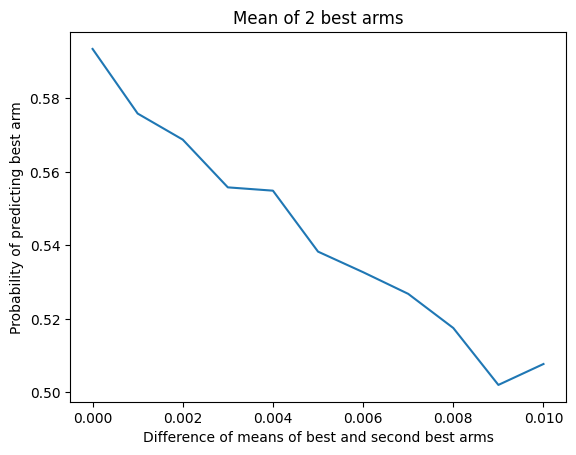

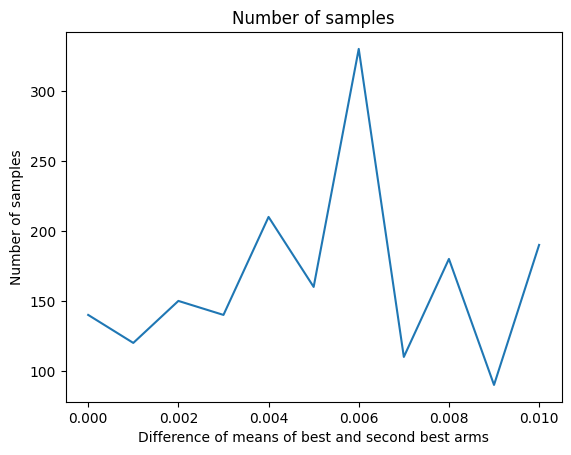

In [10]:
#Test case 2:
#None of the arms violate the threshold, 
#but the means of 2 best arms get closer

num_arms = 3
num_attributes = 2

x_axis, y_axis1, y_axis2, samples = [], [], [], []
for x in range(11):
    num_iter = 10000
    count = np.zeros(num_arms)

    ae2 = Action_Elimination([([0.4, 0.69 + x/1000], [0.25, 0.25]),     #0
                              ([0.5, 0.5], [0.25, 0.25]),               #1
                              ([0.4, 0.7], [0.25, 0.25])])              #2

    for i in range(num_iter):
        best_arm = ae2.start()
        count[best_arm] += 1

    prob = count/num_iter
    x_axis.append(x/1000)
    y_axis1.append(prob[2])
    y_axis2.append(prob[0])
    samples.append(sum([arm.times_pulled for arm in ae2.arms]))
    print(prob)

plt.plot(x_axis, y_axis1)
plt.xlabel("Difference of means of best and second best arms")
plt.ylabel("Probability of predicting best arm")
plt.title("Mean of 2 best arms")
plt.show()

plt.plot(x_axis, samples)
plt.xlabel("Difference of means of best and second best arms")
plt.ylabel("Number of samples")
plt.title("Number of samples")
plt.show()


In [11]:
#Test Case 1
#None of the arms violate the threshold, 
#but the means of 2 best arms get closer

y_axis = {}
y_axis[3], y_axis[4], y_axis[5] = [], [], []
samples = {}
samples[3], samples[4], samples[5] = [], [], []
for num_arms in [3, 4, 5]:
    x_axis = []
    for x in range(11):
        arms_set = [([0.4, 0.69 + x/1000], [0.25, 0.25]),     #0
                    ([0.4, 0.7], [0.25, 0.25]),               #1
                    ([0.5, 0.5], [0.25, 0.25]),               #2
                    ([0.4, 0.4], [0.25, 0.25]),               #3
                    ([0.3, 0.4], [0.25, 0.25])]               #4

        num_iter = 10000
        count = np.zeros(num_arms)
        num_samples = []

        ae2 = Action_Elimination(arms_set[:num_arms])

        for i in range(num_iter):
            best_arm = ae2.start()
            count[best_arm] += 1
            num_samples.append(sum([arm.times_pulled for arm in ae2.arms]))

        prob = count/num_iter
        x_axis.append(0.01 - x/1000)
        y_axis[num_arms].append(prob[1])
        samples[num_arms].append(np.mean(np.array(num_samples))/num_arms)
        print(prob)

[0.4101 0.5899 0.    ]
[4.201e-01 5.798e-01 1.000e-04]
[0.4259 0.5741 0.    ]
[0.4365 0.5635 0.    ]
[0.4485 0.5515 0.    ]
[0.4595 0.5405 0.    ]
[0.4538 0.5462 0.    ]
[0.4737 0.5263 0.    ]
[0.4778 0.5222 0.    ]
[0.4925 0.5075 0.    ]
[0.4931 0.5069 0.    ]
[0.4085 0.5915 0.     0.    ]
[4.269e-01 5.730e-01 1.000e-04 0.000e+00]
[0.4277 0.5723 0.     0.    ]
[0.432 0.568 0.    0.   ]
[0.4448 0.5552 0.     0.    ]
[0.4483 0.5517 0.     0.    ]
[0.4656 0.5344 0.     0.    ]
[0.4772 0.5228 0.     0.    ]
[0.4809 0.5191 0.     0.    ]
[0.4867 0.5133 0.     0.    ]
[0.4942 0.5058 0.     0.    ]
[0.4025 0.5975 0.     0.     0.    ]
[0.4196 0.5804 0.     0.     0.    ]
[0.426 0.574 0.    0.    0.   ]
[4.431e-01 5.568e-01 1.000e-04 0.000e+00 0.000e+00]
[0.4455 0.5545 0.     0.     0.    ]
[0.4592 0.5408 0.     0.     0.    ]
[0.4701 0.5299 0.     0.     0.    ]
[4.771e-01 5.228e-01 1.000e-04 0.000e+00 0.000e+00]
[0.4863 0.5137 0.     0.     0.    ]
[0.4821 0.5179 0.     0.     0.    ]
[0.49

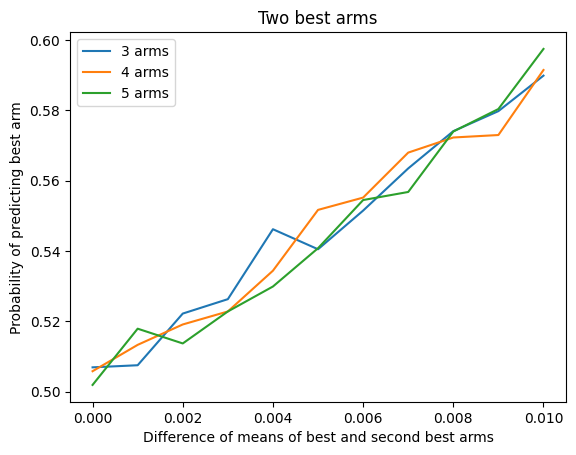

In [12]:
plt.plot(x_axis, y_axis[3])
plt.plot(x_axis, y_axis[4])
plt.plot(x_axis, y_axis[5])
plt.xlabel("Difference of means of best and second best arms")
plt.ylabel("Probability of predicting best arm")
plt.title("Two best arms")
plt.legend(["3 arms", "4 arms", "5 arms"])
plt.show()

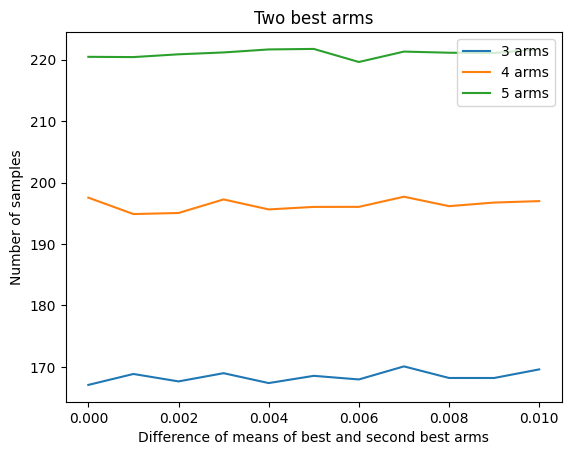

In [13]:
plt.plot(x_axis, samples[3])
plt.plot(x_axis, samples[4])
plt.plot(x_axis, samples[5])
plt.xlabel("Difference of means of best and second best arms")
plt.ylabel("Number of samples")
plt.title("Two best arms")
plt.legend(["3 arms", "4 arms", "5 arms"])
plt.show()

In [16]:
#Test Case 2
#Two best arms have the same mean,
#but one of these violates the threshold

y_axis = {}
y_axis[3], y_axis[4], y_axis[5] = [], [], []
samples = {}
samples[3], samples[4], samples[5] = [], [], []
for num_arms in [3, 4, 5]:
    x_axis = []
    for x in range(21):
        arms_set = [([x/100, 1.1 - (x/100)], [0.25, 0.25]),   #0
            ([0.4, 0.7], [0.25, 0.25]),               #1
            ([0.5, 0.5], [0.25, 0.25]),               #2
            ([0.4, 0.4], [0.25, 0.25]),               #3
            ([0.3, 0.4], [0.25, 0.25])]               #4

        num_iter = 10000
        count = np.zeros(num_arms)
        num_samples = []

        ae3 = Action_Elimination(arms_set[:num_arms])

        for i in range(num_iter):
            best_arm = ae3.start()
            count[best_arm] += 1
            num_samples.append(sum([arm.times_pulled for arm in ae3.arms]))

        prob = count/num_iter
        x_axis.append(x/100)
        y_axis[num_arms].append(prob[1])
        samples[num_arms].append(np.mean(np.array(num_samples))/num_arms)
        print(prob)

[0.0022 0.9906 0.0072]
[0.0023 0.9892 0.0085]
[0.0034 0.9885 0.0081]
[0.006  0.9846 0.0094]
[0.0062 0.985  0.0088]
[0.0083 0.9818 0.0099]
[0.0122 0.9752 0.0126]
[0.0181 0.9685 0.0134]
[0.024  0.9621 0.0139]
[0.0293 0.9568 0.0139]
[0.0415 0.9426 0.0159]
[0.0487 0.9335 0.0178]
[0.0723 0.9081 0.0196]
[0.0968 0.8842 0.019 ]
[0.1302 0.8512 0.0186]
[0.1636 0.8196 0.0168]
[0.2146 0.7665 0.0189]
[0.2592 0.7254 0.0154]
[0.3263 0.6596 0.0141]
[0.4029 0.586  0.0111]
[0.4652 0.5252 0.0096]
[0.0022 0.9887 0.0091 0.    ]
[2.500e-03 9.899e-01 7.400e-03 2.000e-04]
[0.0038 0.9876 0.0086 0.    ]
[0.005  0.9858 0.0092 0.    ]
[0.0063 0.9833 0.0104 0.    ]
[0.0104 0.9801 0.0095 0.    ]
[1.280e-02 9.749e-01 1.220e-02 1.000e-04]
[0.0181 0.9709 0.011  0.    ]
[0.0219 0.9645 0.0136 0.    ]
[0.0296 0.9582 0.0122 0.    ]
[0.0402 0.9458 0.014  0.    ]
[0.0566 0.9279 0.0155 0.    ]
[0.0734 0.9095 0.0171 0.    ]
[0.099  0.8818 0.0192 0.    ]
[0.1343 0.8447 0.021  0.    ]
[0.1667 0.8152 0.0181 0.    ]
[0.2165 0.765

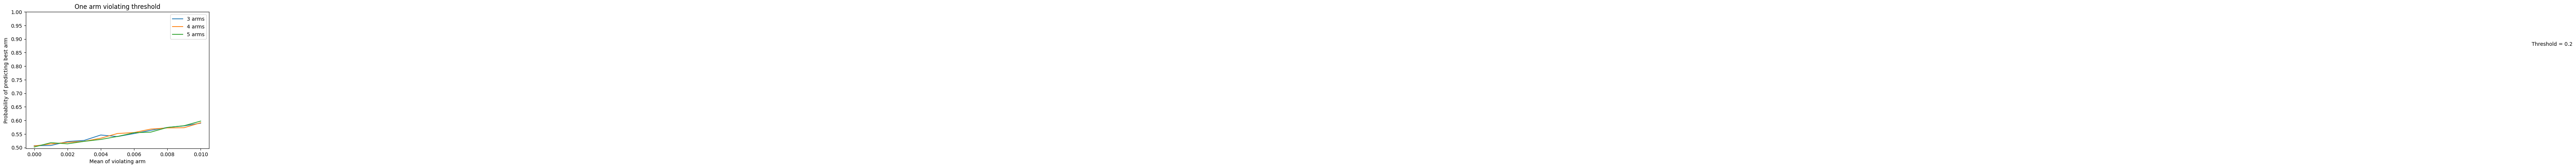

In [15]:
plt.plot(x_axis, y_axis[3])
plt.plot(x_axis, y_axis[4])
plt.plot(x_axis, y_axis[5])
plt.xlabel("Mean of violating arm")
plt.ylabel("Probability of predicting best arm")
plt.yticks(np.array(range(10, 21))/20)
plt.text(0.15, 0.875, 'Threshold = 0.2')
plt.title("One arm violating threshold")
plt.legend(["3 arms", "4 arms", "5 arms"])
plt.show()

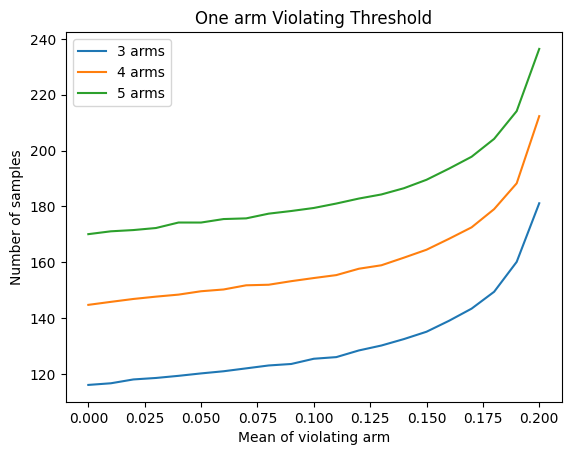

In [ ]:
plt.plot(x_axis, samples[3])
plt.plot(x_axis, samples[4])
plt.plot(x_axis, samples[5])
plt.xlabel("Mean of violating arm")
plt.ylabel("Number of samples")
plt.title("One arm Violating Threshold")
plt.legend(["3 arms", "4 arms", "5 arms"])
plt.show()

In [ ]:
#Test Case 3
#The best arm violates the threshold, 
#and the mean of the second best arm varies

y_axis = {}
y_axis[3], y_axis[4], y_axis[5] = [], [], []
samples = {}
samples[3], samples[4], samples[5] = [], [], []
for num_arms in [3, 4, 5]:
    x_axis = []
    for x in range(21):
        arms_set = [([0.1, 0.9], [0.25, 0.25]),               #0
                    ([0.4, 0.4 + x/50], [0.25, 0.25]),        #1
                    ([0.4, 0.4], [0.25, 0.25]),               #2
                    ([0.3, 0.4], [0.25, 0.25]),               #3
                    ([0.3, 0.3], [0.25, 0.25])]               #4

        num_iter = 10000
        count = np.zeros(num_arms)
        num_samples = []

        ae4 = Action_Elimination(arms_set[:num_arms])

        for i in range(num_iter):
            best_arm = ae4.start()
            count[best_arm] += 1
            num_samples.append(sum([arm.times_pulled for arm in ae4.arms]))

        prob = count/num_iter
        x_axis.append(0.8 + x/50)
        y_axis[num_arms].append(prob[1])
        samples[num_arms].append(np.mean(np.array(num_samples))/num_arms)
        print(prob)

[0.2802 0.3614 0.3584]
[0.2572 0.4669 0.2759]
[0.23  0.575 0.195]
[0.2064 0.6681 0.1255]
[0.1719 0.7596 0.0685]
[0.1512 0.8076 0.0412]
[0.1236 0.8533 0.0231]
[0.1008 0.8857 0.0135]
[0.0773 0.9166 0.0061]
[0.0601 0.9359 0.004 ]
[0.0494 0.9493 0.0013]
[3.41e-02 9.65e-01 9.00e-04]
[2.480e-02 9.749e-01 3.000e-04]
[1.710e-02 9.824e-01 5.000e-04]
[1.09e-02 9.89e-01 1.00e-04]
[7.000e-03 9.929e-01 1.000e-04]
[0.0047 0.9953 0.    ]
[0.0011 0.9989 0.    ]
[8.000e-04 9.992e-01 0.000e+00]
[4.000e-04 9.996e-01 0.000e+00]
[4.000e-04 9.996e-01 0.000e+00]
[0.2711 0.3623 0.3508 0.0158]
[0.256  0.4686 0.2642 0.0112]
[0.2372 0.562  0.1931 0.0077]
[0.2069 0.6702 0.1176 0.0053]
[0.1797 0.7446 0.0735 0.0022]
[1.474e-01 8.111e-01 4.080e-02 7.000e-04]
[0.1234 0.8541 0.0216 0.0009]
[9.890e-02 8.884e-01 1.230e-02 4.000e-04]
[7.680e-02 9.181e-01 5.000e-03 1.000e-04]
[6.230e-02 9.344e-01 3.000e-03 3.000e-04]
[4.31e-02 9.55e-01 1.80e-03 1.00e-04]
[3.620e-02 9.632e-01 6.000e-04 0.000e+00]
[2.490e-02 9.747e-01 4.000

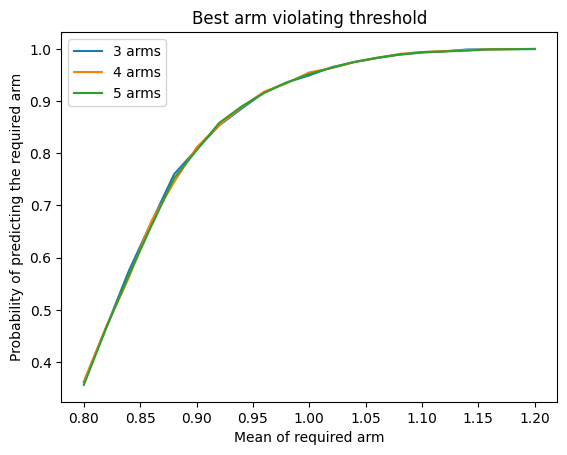

In [ ]:
plt.plot(x_axis, y_axis[3])
plt.plot(x_axis, y_axis[4])
plt.plot(x_axis, y_axis[5])
plt.xlabel("Mean of required arm")
plt.ylabel("Probability of predicting the required arm")
plt.title("Best arm violating threshold")
plt.legend(["3 arms", "4 arms", "5 arms"])
plt.show()

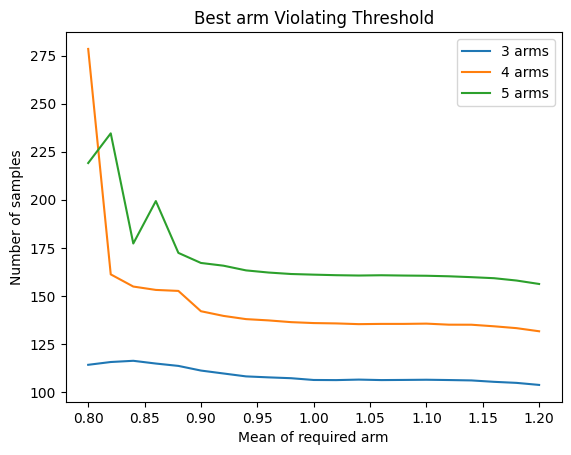

In [ ]:
plt.plot(x_axis, samples[3])
plt.plot(x_axis, samples[4])
plt.plot(x_axis, samples[5])
plt.xlabel("Mean of required arm")
plt.ylabel("Number of samples")
plt.title("Best arm Violating Threshold")
plt.legend(["3 arms", "4 arms", "5 arms"])
plt.show()

In [22]:
#Test case 5:

num_iter = 10000
count = np.zeros(6)
ae5 = Action_Elimination([([1], [0.5]),
                          ([0.8], [0.5]),
                          ([0.6], [0.5]),
                          ([0.4], [0.5]),
                          ([0.2], [0.5]),
                          ([0], [0.5])], uniform_exp = 10)

for i in range(num_iter):
    best_arm = ae5.start()
    count[best_arm] += 1

prob = count/num_iter
print(prob)

[0.9857 0.0143 0.     0.     0.     0.    ]
